In [2]:
# Question 6: Implement the LeNet-5 architectures using Tensorflow or PyTorch to classify the MNIST dataset. Report the accuracy and training time.
#Answer

# LeNet-5 implementation on MNIST using PyTorch

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import time

# LeNet-5 Model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # FIXED
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Data loaders
transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=False, transform=transform),
    batch_size=1000, shuffle=False
)

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
start_time = time.time()
epochs = 5

for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

training_time = time.time() - start_time

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total

print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Training Time: {training_time:.2f} seconds")


Test Accuracy: 98.16%
Training Time: 54.57 seconds


In [5]:
# Question 7: Use a pre-trained VGG16 model (via transfer learning) on a small custom dataset (e.g., flowers or animals). Replace the top layers and fine-tune the model. Include your code and result discussion.
#Answer
# Transfer Learning with VGG16 on a small custom dataset (Flowers)
# Framework: TensorFlow / Keras

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load dataset
(ds_train, ds_val), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = ds_info.features["label"].num_classes

# Preprocessing
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image, tf.one_hot(label, NUM_CLASSES)

ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# Load VGG16
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

# Custom head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(base_model.input, outputs)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=5
)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 498ms/step - accuracy: 0.4003 - loss: 1.4403 - val_accuracy: 0.7221 - val_loss: 0.8484
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - accuracy: 0.6864 - loss: 0.8437 - val_accuracy: 0.7779 - val_loss: 0.6810
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.7436 - loss: 0.7121 - val_accuracy: 0.7943 - val_loss: 0.6008
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.7745 - loss: 0.6477 - val_accuracy: 0.8079 - val_loss: 0.5662
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - accuracy: 0.7948 - loss: 0.5992 - val_accuracy: 0.8093 - val_loss: 0.5506


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


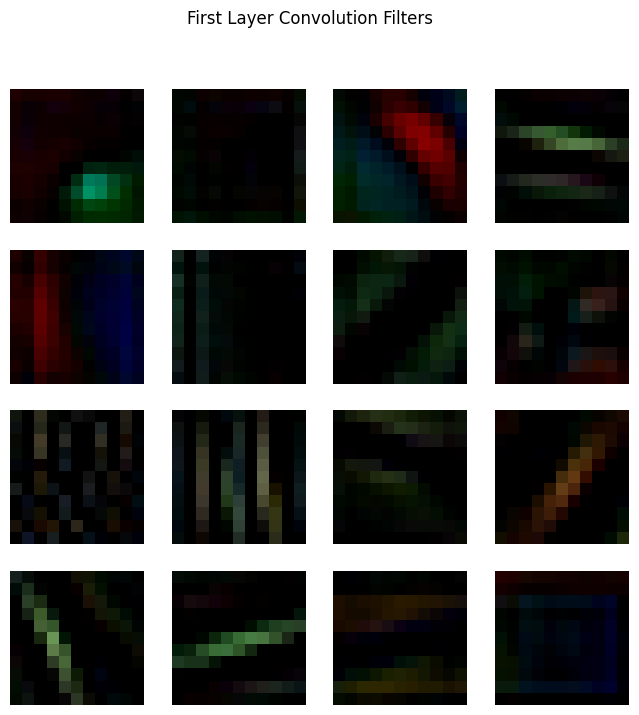

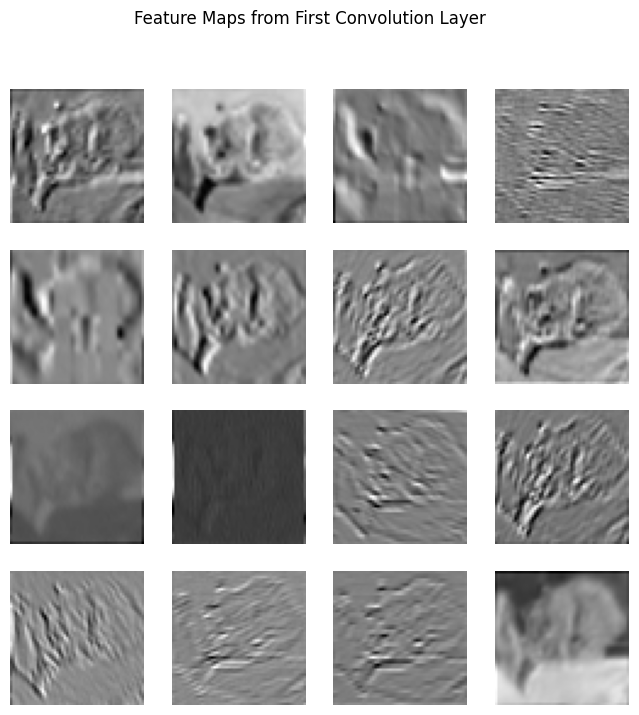

In [8]:
#Question 8: Write a program to visualize the filters and feature maps of the first convolutional layer of AlexNet on an example input image.
# Answer:

# Visualizing filters and feature maps of the first convolutional layer of AlexNet
# Framework: PyTorch

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load pre-trained AlexNet
model = models.alexnet(pretrained=True)
model.eval()

# Extract first convolutional layer
first_conv = model.features[0]

# Load and preprocess image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

from torchvision.datasets import CIFAR10
from PIL import Image

dataset = CIFAR10(root="./data", train=False, download=True)
img, _ = dataset[0]   # PIL image
img = img.resize((224, 224))

input_img = transform(img).unsqueeze(0)

# Forward pass through first conv layer
with torch.no_grad():
    feature_maps = first_conv(input_img)

# Visualize convolutional filters
filters = first_conv.weight.data

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(filters[i].permute(1, 2, 0))
    plt.axis("off")
plt.suptitle("First Layer Convolution Filters")
plt.show()

# Visualize feature maps
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(feature_maps[0, i].cpu(), cmap="gray")
    plt.axis("off")
plt.suptitle("Feature Maps from First Convolution Layer")
plt.show()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.2439 - loss: 1.9773 - val_accuracy: 0.4342 - val_loss: 1.5394
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4450 - loss: 1.4914 - val_accuracy: 0.4962 - val_loss: 1.3525
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5180 - loss: 1.3020 - val_accuracy: 0.5455 - val_loss: 1.2450
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5636 - loss: 1.1981 - val_accuracy: 0.5658 - val_loss: 1.1665
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5973 - loss: 1.1094 - val_accuracy: 0.6326 - val_loss: 1.0248
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6192 - loss: 1.0507 - val_accuracy: 0.6379 - val_loss: 1.0134
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6454 - loss: 0.9837 - val_accuracy: 0.6413 - val_loss: 0.9964
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9

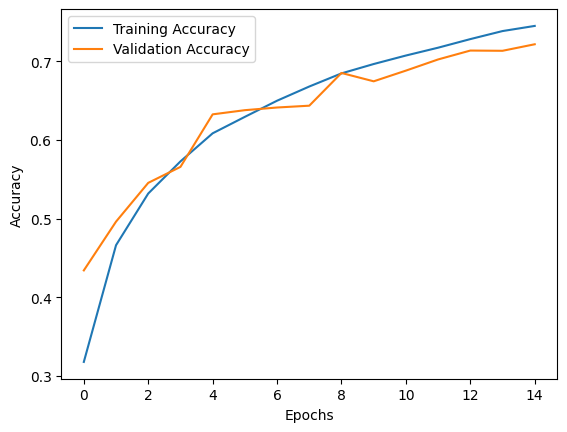

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7260 - loss: 0.7738
Test Accuracy: 72.17%


In [9]:
# Question 9: Train a GoogLeNet (Inception v1) or its variant using a standard dataset like CIFAR-10. Plot the training and validation accuracy over epochs and analyze overfitting or underfitting.
# Answer
# Training GoogLeNet (Inception v1) on CIFAR-10
# Framework: TensorFlow / Keras

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Inception module
def inception_module(x, f1, f3_in, f3, f5_in, f5, pool_proj):
    p1 = layers.Conv2D(f1, (1,1), activation='relu', padding='same')(x)
    p2 = layers.Conv2D(f3_in, (1,1), activation='relu', padding='same')(x)
    p2 = layers.Conv2D(f3, (3,3), activation='relu', padding='same')(p2)
    p3 = layers.Conv2D(f5_in, (1,1), activation='relu', padding='same')(x)
    p3 = layers.Conv2D(f5, (5,5), activation='relu', padding='same')(p3)
    p4 = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    p4 = layers.Conv2D(pool_proj, (1,1), activation='relu', padding='same')(p4)
    return layers.concatenate([p1, p2, p3, p4], axis=-1)

# Build simplified GoogLeNet
inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2,2))(x)

x = inception_module(x, 32, 48, 64, 8, 16, 16)
x = inception_module(x, 64, 64, 96, 16, 48, 32)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(x_test, y_test)
)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Final evaluation
loss, acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")



In [10]:
# Question 10: You are working in a healthcare AI startup. Your team is tasked with developing a system that automatically classifies medical X-ray images into normal, pneumonia, and COVID-19. Due to limited labeled data, what approach would you suggest using among CNN architectures discussed (e.g., transfer learning with ResNet or Inception variants)? Justify your approach and outline a deployment strategy for production use.
# Answer
# Recommended Architecture

# Transfer learning with a pre-trained ResNet (e.g., ResNet-50) is the most suitable approach.

# Justification

# Limited labeled data
# Transfer learning leverages features learned from large datasets (ImageNet), reducing data requirements.

# Deep feature extraction
# ResNet’s residual connections enable very deep networks to train stably, capturing subtle medical patterns in X-rays.

# Proven performance in medical imaging
# ResNet variants are widely used in radiology tasks and show strong generalization.

# Efficient fine-tuning
# Only the top layers need retraining, lowering computational cost and overfitting risk.

# Compared to Inception:

# ResNet is simpler to fine-tune, easier to deploy, and more stable with small datasets.

# Deployment Strategy (Production)

# Model Training

# Use pre-trained ResNet-50

# Freeze early layers, fine-tune last blocks

# Apply data augmentation (rotation, contrast, flip)

# Validation & Safety

# Use cross-validation

# Monitor sensitivity/recall (critical in healthcare)

# Human-in-the-loop for uncertain predictions

# Deployment

# Convert model to TensorFlow SavedModel / ONNX

# Deploy via REST API (FastAPI)

# Use GPU inference if available

# Log predictions for continuous monitoring

# Compliance

# Ensure data anonymization

# Maintain audit logs for predictions

# Follow healthcare regulations (HIPAA-like standards)

# Example Python Code (Transfer Learning with ResNet-50)
# # Transfer Learning for X-ray Classification using ResNet50
# # Framework: TensorFlow / Keras

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load base model
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(3, activation="softmax")(x)  # Normal, Pneumonia, COVID-19

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)